# Dynamic Matrix Control

## Question

Consider following process with transfer function $G_p(s)$:

$$
g_p(s)=\frac
{0.5848(-0.3549s+1)}
{0.1828s^2+0.8627s+1}
$$

plot response using DMC with parameters:

|$\Delta t$|N|P|M|
|---|---|---|---|
|0.1|50|25|1|
|0.1|50|10|1|
|0.1|50| 8|1|
|0.1|50| 7|1|

In [1]:
#import packages
import numpy as np;
import control;
import matplotlib.pyplot as plt;

## 1 Finite Step Response

In [2]:
num=0.5849*np.array([-0.3549,1.0])
den=[0.1828,0.8627,1.0]
Gp=control.tf(num,den)
print(Gp)


   -0.2076 s + 0.5849
-------------------------
0.1828 s^2 + 0.8627 s + 1



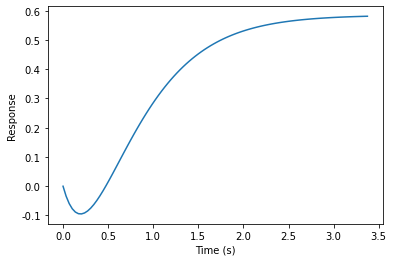

In [3]:
(T,yout)=control.step_response(Gp)
plt.plot(T,yout)
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.show()

## Dynamic Matrix Control

In [4]:
from simupy.block_diagram import BlockDiagram
import simupy.systems

def ModelPredictiveControl(delta_t,N,P,M):
    #获取系统阶跃响应信号
    T=np.arange(N+1)*delta_t
    (T,S)=control.step_response(Gp,T)
    Wm=np.zeros((P,M))
    Q=np.diagflat(np.ones((1,P)))
    R=np.zeros((M,M))#np.diagflat(np.ones((1,M)))
    for i in range(P):
        for j in range(M):
            if i+j>=min(M,P):
                Wm[i,j]=S[i+j-min(M,P)+1]
    a=(np.dot(np.dot(Wm.T,Q),Wm)+R)
    Km=np.dot(np.linalg.inv(a),np.dot(Wm.T,Q))

    h=np.ones((N+1,1))*0.5
    lastU=0
    def MPC(t,input):
        global lastU
        if t%delta_t == 0:
            [y,r]=input
            y0=np.ones((N+1,1))*r # 目标值
            Yr=np.ones((P,1))*r #目标值
            ycor=y0+h*(y-y0[0])
            y0=np.dot(S,ycor)
            E=Yr-y0
            Um=np.dot(Km,E)
            lastU=Um[0]
            return np.array(Um[0])
        else:
            return np.array(lastU)
    return MPC

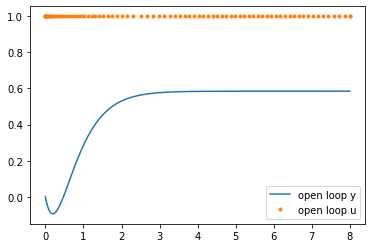

In [5]:
Gp_ss=control.tf2ss(Gp)
process=simupy.systems.LTISystem(Gp_ss.A,Gp_ss.B,Gp_ss.C)
# construct reference
ref = simupy.systems.SystemFromCallable(lambda *args: np.ones(1), 0, 1)

list=[
    (0.1,50,25,1),
    (0.1,50,10,1),
    (0.1,50,8,1),
    (0.1,50,7,1),
]

plt.figure()

controller=simupy.systems.SystemFromCallable(
    lambda t,u:np.array(u[1]),
    2,1)

BD=BlockDiagram(controller,process,ref)
BD.connect(controller,process)
BD.connect(process,controller,outputs=[0],inputs=[0])
BD.connect(ref,controller,outputs=[0],inputs=[1])

result=BD.simulate(8)
plt.plot(result.t, result.y[:,1], label="open loop y")
plt.plot(result.t, result.y[:,0],".", label="open loop u")
plt.legend()
plt.show()

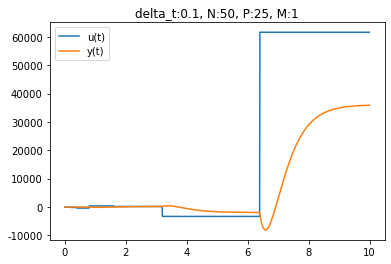

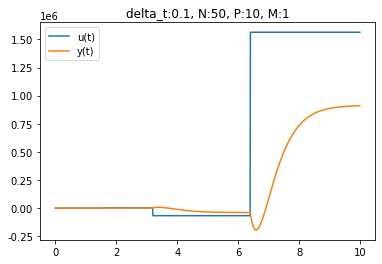

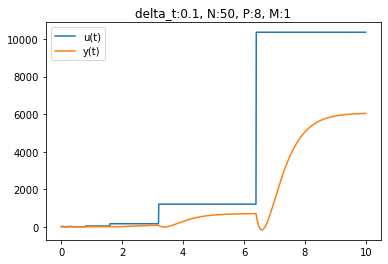

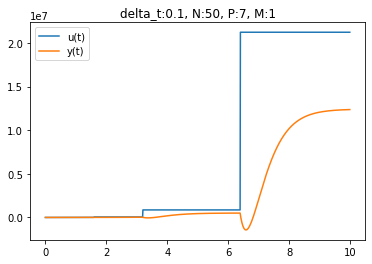

In [8]:
for (delta_t,N,P,M) in list:
    title="delta_t:%.1f, N:%d, P:%d, M:%d"%(delta_t,N,P,M)
    
    controller=simupy.systems.SystemFromCallable(
        ModelPredictiveControl(delta_t,N,P,M),
        2,1)

    BD=BlockDiagram(controller,process,ref)
    BD.connect(controller,process)
    BD.connect(process,controller,outputs=[0],inputs=[0])
    BD.connect(ref,controller,outputs=[0],inputs=[1])

    result=BD.simulate(np.arange(0,10,0.01))
    plt.plot(result.t, result.y[:,0],"-", label="u(t)")
    plt.plot(result.t, result.y[:,1],label="y(t)")
    plt.title(title)
    plt.legend()
    plt.show()

## References

- Siang Lim.February 2020.[Implementing Dynamic Matrix Control in Python](https://github.com/csianglim/DMC/blob/master/DMC.ipynb)
- Matlab.[Dynamic Matrix Control Tutorial](https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/19479/versions/1/previews/html/dmctutorial.html)